### Configuration & Imports

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib as mpl
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.image import imread

sns.set(style="whitegrid", context="talk")

# =========================================================
# GLOBAL CONFIGURATION
# =========================================================
DATA_PATH = os.path.join('data', 'UnderStat24-25.xlsx')
LOGO_DIR = 'logos'

print("Libraries imported and paths configured.")

Libraries imported and paths configured.


### Data Loading & Processing

In [21]:
# =========================================================
# DATA LOADING & CLEANING
# =========================================================

# Helper function to clean Understat strings
def extract_main_value(s):
    if isinstance(s, str):
        s = s.strip()
        for sep in ['+', '-']:
            if sep in s[1:]:
                parts = s.split(sep)
                return float(parts[0])
        try:
            return float(s)
        except ValueError:
            return np.nan
    return s

# Load Data
df = pd.read_excel(DATA_PATH)

# Clean Columns with +/- values
cols_with_plus_minus = ["xG", "NPxG", "xGA", "NPxGA", "NPxGD", "xPTS"]
for col in cols_with_plus_minus:
    if col in df.columns:
        df[col] = df[col].apply(extract_main_value)

# Rename Columns
df = df.rename(columns={
    "№": "rank", "Team": "team", "M": "matches",
    "G": "goals_for", "GA": "goals_against"
})

# Convert to Numeric
num_cols = [
    "rank", "matches", "W", "D", "L", "goals_for", "goals_against",
    "PTS", "xG", "NPxG", "xGA", "NPxGA", "NPxGD",
    "PPDA", "OPPDA", "DC", "ODC", "xPTS"
]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# =========================================================
# 3. FEATURE ENGINEERING
# =========================================================

# Per Match Metrics
df["xG_per_match"] = df["xG"] / df["matches"]
df["xGA_per_match"] = df["xGA"] / df["matches"]
df["goals_for_per_match"] = df["goals_for"] / df["matches"]
df["goals_against_per_match"] = df["goals_against"] / df["matches"]
df["DC_per_match"] = df["DC"] / df["matches"]
df["ODC_per_match"] = df["ODC"] / df["matches"]

# Differentials & Overperformance
df["goal_diff"] = df["goals_for"] - df["goals_against"]
df["xg_diff"] = df["xG"] - df["xGA"]
df["xg_overperf"] = df["goals_for"] - df["xG"]
df["pts_overperf"] = df["PTS"] - df["xPTS"]

# Normalization (0-1) for Radar Charts
def min_max_norm(s):
    return (s - s.min()) / (s.max() - s.min())

df["norm_xG"] = min_max_norm(df["xG_per_match"])
df["norm_xGA_inv"] = min_max_norm(-df["xGA_per_match"])
df["norm_PPDA_inv"] = min_max_norm(-df["PPDA"])
df["norm_DC"] = min_max_norm(df["DC"])
df["norm_ODC_inv"] = min_max_norm(-df["ODC"])
df["norm_xPTS"] = min_max_norm(df["xPTS"] / df["matches"])

# Save cleaned dataset
df.to_csv("serie_a_24_25_clean_enrich.csv", index=False)
print("Data processed successfully.")
display(df)

Data processed successfully.


,rank,team,matches,W,D,L,goals_for,goals_against,PTS,xG,...,goal_diff,xg_diff,xg_overperf,pts_overperf,norm_xG,norm_xGA_inv,norm_PPDA_inv,norm_DC,norm_ODC_inv,norm_xPTS
0,1,Napoli,38,24,10,4,59,27,82,57.05,...,32,25.50,1.95,11.02,0.522094,1.000000,0.519362,0.613734,0.857143,0.900471
1,2,Inter,38,24,9,5,79,35,81,76.74,...,44,34.31,2.26,5.58,0.934450,0.684272,0.652620,1.000000,0.876190,1.000000
2,3,Atalanta,38,22,8,8,78,37,74,79.87,...,41,37.55,-1.87,-1.23,1.000000,0.687464,0.574032,0.828326,1.000000,0.995741
3,4,Juventus,38,18,16,4,58,35,70,58.12,...,23,22.76,-0.12,0.49,0.544503,0.889437,0.752847,0.515021,0.933333,0.867518
4,5,Roma,38,20,9,9,56,35,69,62.07,...,21,14.01,-6.07,7.25,0.627225,0.520894,0.476082,0.656652,0.704762,0.693566
5,6,Fiorentina,38,19,8,11,60,41,65,54.11,...,19,7.35,5.89,9.39,0.460524,0.558619,0.346241,0.296137,0.542857,0.555929
6,7,Lazio,38,18,11,9,61,49,65,65.32,...,12,21.83,-4.32,-1.78,0.695288,0.653511,0.559226,0.442060,0.857143,0.806321
7,8,Milan,38,18,9,11,61,43,63,69.51,...,18,22.24,-8.51,-5.40,0.783037,0.543819,0.461276,0.721030,0.523810,0.842636
8,9,Bologna,38,16,14,8,57,47,62,57.18,...,10,15.80,-0.18,0.18,0.524817,0.714742,1.000000,0.270386,1.000000,0.695136
9,10,Como,38,13,10,15,49,52,49,49.76,...,-3,-0.35,-0.76,-2.39,0.369424,0.461405,0.673121,0.510730,0.809524,0.461332


### Visualization Helpers (Logos)

In [22]:
# =========================================================
# VISUALIZATION HELPERS (LOGOS)
# =========================================================

teams = [
    "Napoli", "Inter", "Atalanta", "Juventus", "Roma", "Fiorentina", 
    "Lazio", "Milan", "Bologna", "Como", "Torino", "Udinese", 
    "Genoa", "Verona", "Parma", "Cagliari", "Lecce", "Empoli", 
    "Venezia", "Monza"
]

team_logo_map = {team: os.path.join(LOGO_DIR, f"{team}.png") for team in teams}

def add_logo(ax, x, y, team, zoom=0.06):
    """
    Adds a team logo at coordinates (x, y).
    """
    path = team_logo_map.get(team)
    if path is None or not os.path.exists(path):
        return
    try:
        img = imread(path)
        im = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)
    except Exception as e:
        print(f"Error loading logo for {team}: {e}")

print("Visualization helpers ready.")

Visualization helpers ready.


### Performance Matrix

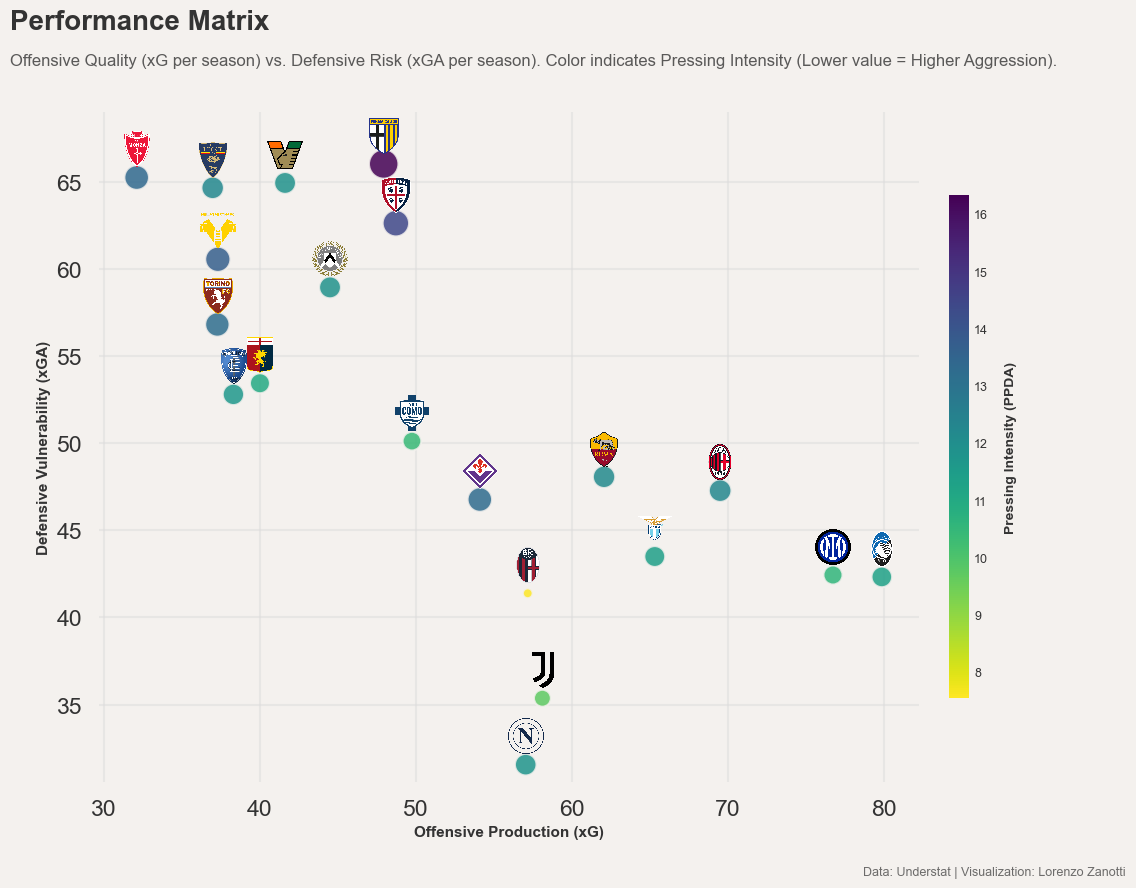

In [23]:
# =========================================================
# CHART 1: PERFORMANCE MATRIX (xG vs xGA)
# =========================================================

# --- 1. VISUAL STYLE CONFIGURATION ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

# Apply Global Style for this chart
plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': False
})

# --- 2. PLOT GENERATION ---
fig, ax = plt.subplots(figsize=(12, 9))

# Scatter: Size/Color based on PPDA
sns.scatterplot(
    data=df,
    x="xG",
    y="xGA",
    size="PPDA",
    sizes=(50, 450),
    hue="PPDA",
    palette="viridis_r",
    alpha=0.85,
    edgecolor=BG_COLOR,
    linewidth=1.5,
    ax=ax,
    legend=False
)

# Set Axis Limits (Manual adjustment for layout breathing room)
y_min = df["xGA"].min() - 1
y_max = df["xGA"].max() + 3
ax.set_ylim(y_min, y_max)

# --- 3. ANNOTATIONS (LOGOS) ---
for _, row in df.iterrows():
    x, y, team = row["xG"], row["xGA"], row["team"]
    # Offset logo slightly above the dot
    y_logo = y + 1.6
    add_logo(ax, x, y_logo, team, zoom=0.017)

# --- 4. COLORBAR ---
norm = mpl.colors.Normalize(vmin=df["PPDA"].min(), vmax=df["PPDA"].max())
cmap = mpl.colormaps["viridis_r"] # Updated to avoid warning

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.03, shrink=0.75, aspect=25)
cbar.set_label("Pressing Intensity (PPDA)", color=TEXT_COLOR, fontsize=10, labelpad=12, fontweight='bold')
cbar.ax.yaxis.set_tick_params(color=TEXT_COLOR, size=0)
cbar.outline.set_visible(False)
plt.setp(cbar.ax.get_yticklabels(), color=TEXT_COLOR, fontsize=9)

# --- 5. TITLES & LABELS ---
ax.set_xlabel("Offensive Production (xG)", fontsize=11, fontweight='bold')
ax.set_ylabel("Defensive Vulnerability (xGA)", fontsize=11, fontweight='bold')
ax.grid(alpha=0.5)

# Main Title & Subtitle
fig.text(0.02, 0.96, "Performance Matrix",
         fontsize=20, fontweight='bold', ha='left', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Offensive Quality (xG per season) vs. Defensive Risk (xGA per season). Color indicates Pressing Intensity (Lower value = Higher Aggression).",
         fontsize=12, ha='left', color=TEXT_COLOR, alpha=0.8)

# Footer
fig.text(0.95, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.90])
plt.show()

### Territorial Control Map

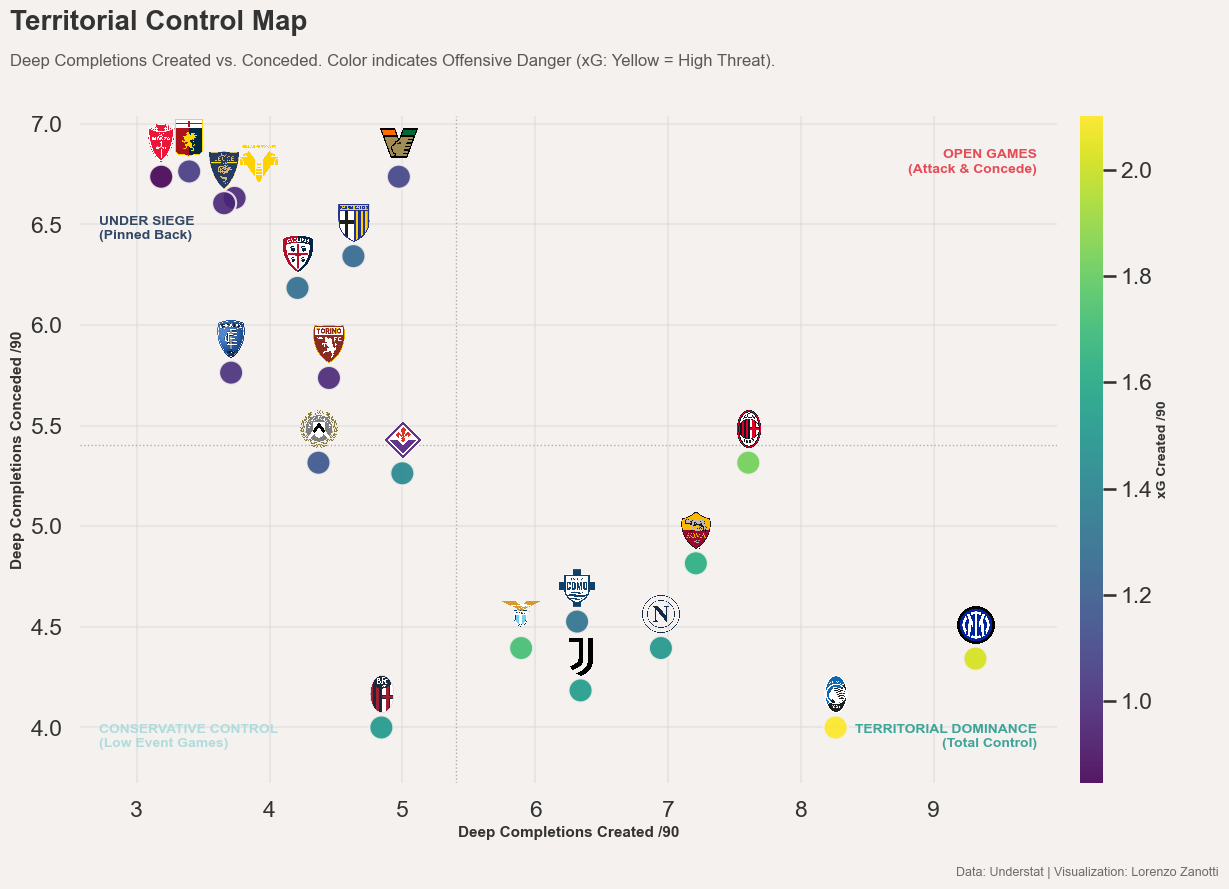

In [24]:
# =========================================================
# CHART 2: TERRITORIAL CONTROL (DC vs ODC)
# =========================================================

# --- 1. STYLE REFRESH (Optional but safe) ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': False
})

# --- 2. PLOT GENERATION ---
fig, ax = plt.subplots(figsize=(13, 9))

# Scatter Plot: Color maps to xG Intensity
scatter = ax.scatter(
    df["DC_per_match"], 
    df["ODC_per_match"], 
    c=df["xG_per_match"], 
    s=300, 
    cmap="viridis", 
    alpha=0.9,
    edgecolor=BG_COLOR,
    linewidth=1.5,
    zorder=2
)

# --- 3. LOGOS PLACEMENT & ADJUSTMENTS ---
# Calculate dynamic margins
x_min, x_max = df["DC_per_match"].min(), df["DC_per_match"].max()
y_min, y_max = df["ODC_per_match"].min(), df["ODC_per_match"].max()
margin_x = (x_max - x_min) * 0.1
margin_y = (y_max - y_min) * 0.1

ax.set_xlim(x_min - margin_x, x_max + margin_x)
ax.set_ylim(y_min - margin_y, y_max + margin_y)

for _, row in df.iterrows():
    # Base position
    x_pos = row["DC_per_match"]
    y_pos = row["ODC_per_match"] + (margin_y * 0.6) # Shift logo up
    
    # MANUAL ADJUSTMENTS
    if row["team"] == "Verona":
        x_pos += (margin_x * 0.3) # Shift right to avoid overlap
    
    add_logo(ax, x_pos, y_pos, row["team"], zoom=0.018)

# --- 4. QUADRANTS & MEAN LINES ---
x_mean = df["DC_per_match"].mean()
y_mean = df["ODC_per_match"].mean()

# Mean lines (subtle)
ax.axhline(y_mean, color='#B0B0B0', linestyle=':', linewidth=1, zorder=1)
ax.axvline(x_mean, color='#B0B0B0', linestyle=':', linewidth=1, zorder=1)

# Quadrant Labels (Fixed corners)
# Top-Right: Open Games
ax.text(0.98, 0.95, "OPEN GAMES\n(Attack & Concede)", transform=ax.transAxes,
        ha='right', va='top', color='#E63946', fontsize=10, fontweight='bold', alpha=0.9)

# Bottom-Right: Dominance
ax.text(0.98, 0.05, "TERRITORIAL DOMINANCE\n(Total Control)", transform=ax.transAxes,
        ha='right', va='bottom', color='#2A9D8F', fontsize=10, fontweight='bold', alpha=0.9)

# Bottom-Left: Conservative
ax.text(0.02, 0.05, "CONSERVATIVE CONTROL\n(Low Event Games)", transform=ax.transAxes,
        ha='left', va='bottom', color='#A8DADC', fontsize=10, fontweight='bold', alpha=0.9)

# Top-Left: Under Siege
ax.text(0.02, 0.85, "UNDER SIEGE\n(Pinned Back)", transform=ax.transAxes,
        ha='left', va='top', color='#1D3557', fontsize=10, fontweight='bold', alpha=0.9)

# --- 5. COLORBAR & LABELS ---
cbar = plt.colorbar(scatter, ax=ax, pad=0.02, aspect=30)
cbar.set_label("xG Created /90", fontsize=10, fontweight='bold')
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(color=TEXT_COLOR)

ax.set_xlabel("Deep Completions Created /90", fontsize=11, fontweight='bold')
ax.set_ylabel("Deep Completions Conceded /90", fontsize=11, fontweight='bold')
ax.grid(alpha=0.5)

# Titles
fig.text(0.02, 0.96, "Territorial Control Map", fontsize=20, fontweight='bold', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Deep Completions Created vs. Conceded. Color indicates Offensive Danger (xG: Yellow = High Threat).", fontsize=12, color=TEXT_COLOR, alpha=0.8)
fig.text(0.95, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

### Clustering & PCA

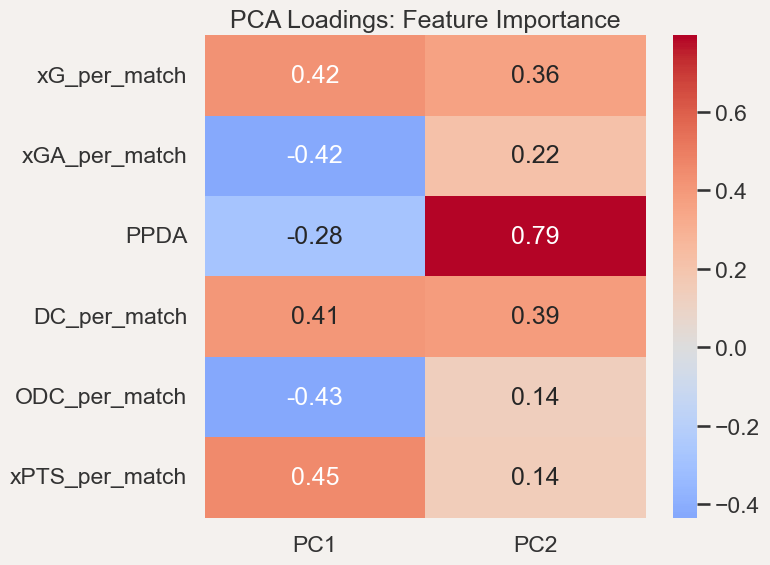

In [25]:
# =========================================================
# DATA PREP FOR CLUSTERING (K-Means & PCA)
# =========================================================

# --- 1. FEATURE SELECTION & PREP ---
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull

# --- FIX PER WINDOWS/KMEANS MEMORY LEAK ---
os.environ["OMP_NUM_THREADS"] = "1"

# Ensure all needed metrics are per-match
metrics_to_check = ["xG", "xGA", "DC", "ODC", "xPTS"]
for col in metrics_to_check:
    if f"{col}_per_match" not in df.columns:
        df[f"{col}_per_match"] = df[col] / df["matches"]

# Features used for clustering
cluster_features = [
    "xG_per_match", "xGA_per_match", "PPDA", 
    "DC_per_match", "ODC_per_match", "xPTS_per_match"
]

X = df[cluster_features].copy()
X_std = StandardScaler().fit_transform(X)

import warnings
# Ignore warning, graphically meticulous
warnings.filterwarnings("ignore", message=".*KMeans is known to have a memory leak.*")

# --- 2. K-MEANS CLUSTERING (K=4) ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
df["StyleCluster"] = kmeans.fit_predict(X_std)

# --- 3. PCA CALCULATION ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

# --- 4. INTERPRETATION HEATMAP ---
# This helps explain what PC1 and PC2 actually represent
loadings = pd.DataFrame(
    pca.components_.T,
    index=cluster_features,
    columns=["PC1", "PC2"]
)

plt.figure(figsize=(8, 6))
# Using standard seaborn style for this analytical tool only
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings: Feature Importance")
plt.tight_layout()
plt.show()

### The Four Tactical Archetypes

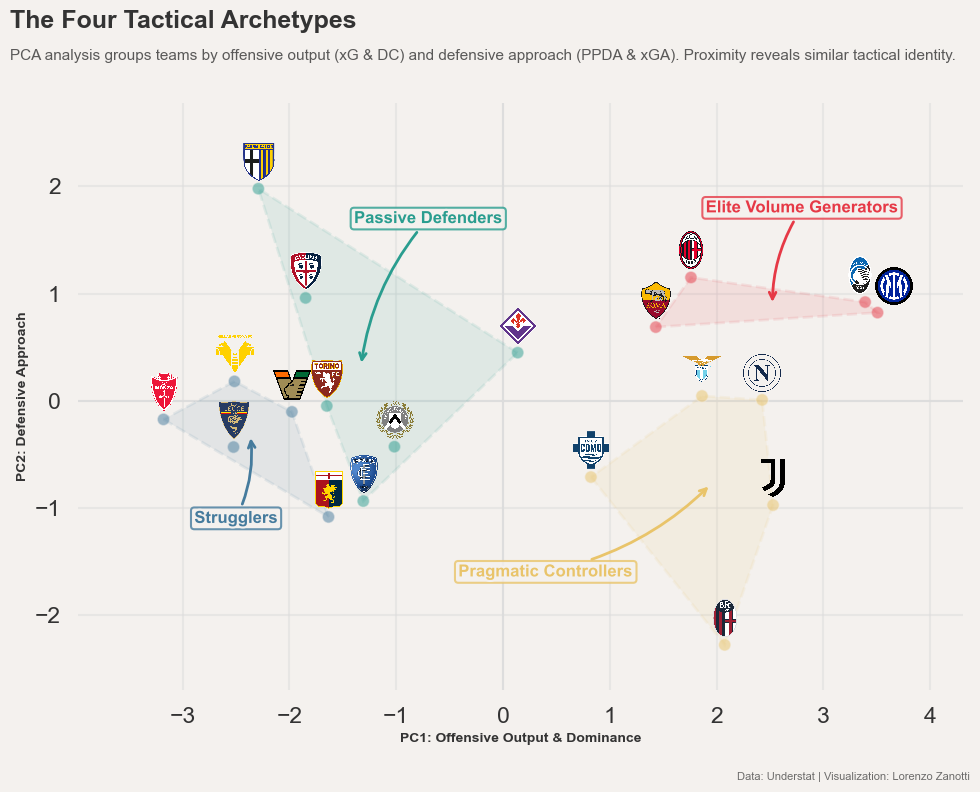

In [26]:
# =========================================================
# CHART 3: TACTICAL ARCHETYPES 
# =========================================================

# --- 1. VISUAL STYLE REFRESH ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': False
})

# --- 2. CLUSTER CONFIGURATION ---
# Mappings based on analysis 
cluster_mapping = {
    0: "Elite Volume Generators",   
    1: "Strugglers",                
    2: "Pragmatic Controllers",     
    3: "Passive Defenders"          
}

cluster_colors = ['#E63946', '#457B9D', '#E9C46A', '#2A9D8F'] # Red, Blue, Gold, Teal

# Manual Label Positions 
label_positions = {
    0: (2.8, 1.8),    # Elite
    1: (-2.5, -1.1),  # Strugglers
    2: (0.4, -1.6),   # Pragmatic
    3: (-0.7, 1.7)    # Passive
}

# --- 3. PLOT GENERATION ---
fig, ax = plt.subplots(figsize=(10, 8)) 

# Base Scatter
sns.scatterplot(
    data=df, x="PC1", y="PC2", hue="StyleCluster",
    palette=cluster_colors, s=80, alpha=0.5, 
    edgecolor=BG_COLOR, linewidth=1, ax=ax, legend=False
)

# --- 4. CONVEX HULLS & ANNOTATIONS ---
for i, color in enumerate(cluster_colors):
    points = df[df["StyleCluster"] == i][["PC1", "PC2"]].values
    
    if len(points) > 2:
        # Draw Hull Area
        hull = ConvexHull(points)
        polygon = plt.Polygon(
            points[hull.vertices], closed=True, facecolor=color, alpha=0.1,
            edgecolor=color, linewidth=2, linestyle='--'
        )
        ax.add_patch(polygon)
        
        # Label & Arrow
        center = np.mean(points, axis=0)
        label = cluster_mapping.get(i, f"Group {i+1}")
        pos_x, pos_y = label_positions.get(i, (center[0], center[1]))
        
        ax.annotate(
            label, 
            xy=(center[0], center[1]),      
            xytext=(pos_x, pos_y),          
            textcoords='data',
            arrowprops=dict(
                arrowstyle="->",            
                color=color,                
                lw=2, 
                connectionstyle="arc3,rad=0.15" 
            ),
            fontsize=12, fontweight='bold', color=color, ha='center', va='center',
            path_effects=[path_effects.withStroke(linewidth=3, foreground=BG_COLOR)],
            bbox=dict(boxstyle="round,pad=0.2", fc=BG_COLOR, ec=color, alpha=0.8)
        )

# --- 5. LOGOS (With Manual Adjustments) ---
# Set Limits
x_vals = df["PC1"]
y_vals = df["PC2"]
margin_x = 0.8
ax.set_xlim(x_vals.min() - margin_x, x_vals.max() + margin_x)
ax.set_ylim(-2.7, y_vals.max() + 0.8)

for _, row in df.iterrows():
    x, y, team = row["PC1"], row["PC2"], row["team"]
    
    # Manual Adjustments for overlaps
    x_pos = x
    if "Inter" in team: 
        x_pos = x + 0.15 
    if "Atalanta" in team: 
        x_pos = x - 0.05 
    
    add_logo(ax, x_pos, y + 0.25, team, zoom=0.018) 

# --- 6. TITLES & FORMATTING ---
ax.axhline(0, color=GRID_COLOR, linestyle='-', linewidth=1.5, alpha=0.8, zorder=0)
ax.axvline(0, color=GRID_COLOR, linestyle='-', linewidth=1.5, alpha=0.8, zorder=0)
ax.grid(alpha=0.5)

ax.set_xlabel("PC1: Offensive Output & Dominance", fontsize=10, fontweight='bold')
ax.set_ylabel("PC2: Defensive Approach", fontsize=10, fontweight='bold')

# Header
fig.text(0.02, 0.96, "The Four Tactical Archetypes", fontsize=18, fontweight='bold', color=TEXT_COLOR)
fig.text(0.02, 0.92, "PCA analysis groups teams by offensive output (xG & DC) and defensive approach (PPDA & xGA). Proximity reveals similar tactical identity.", fontsize=11, color=TEXT_COLOR, alpha=0.8)
fig.text(0.98, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", ha='right', fontsize=8, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

### Clinicians vs Wasteful

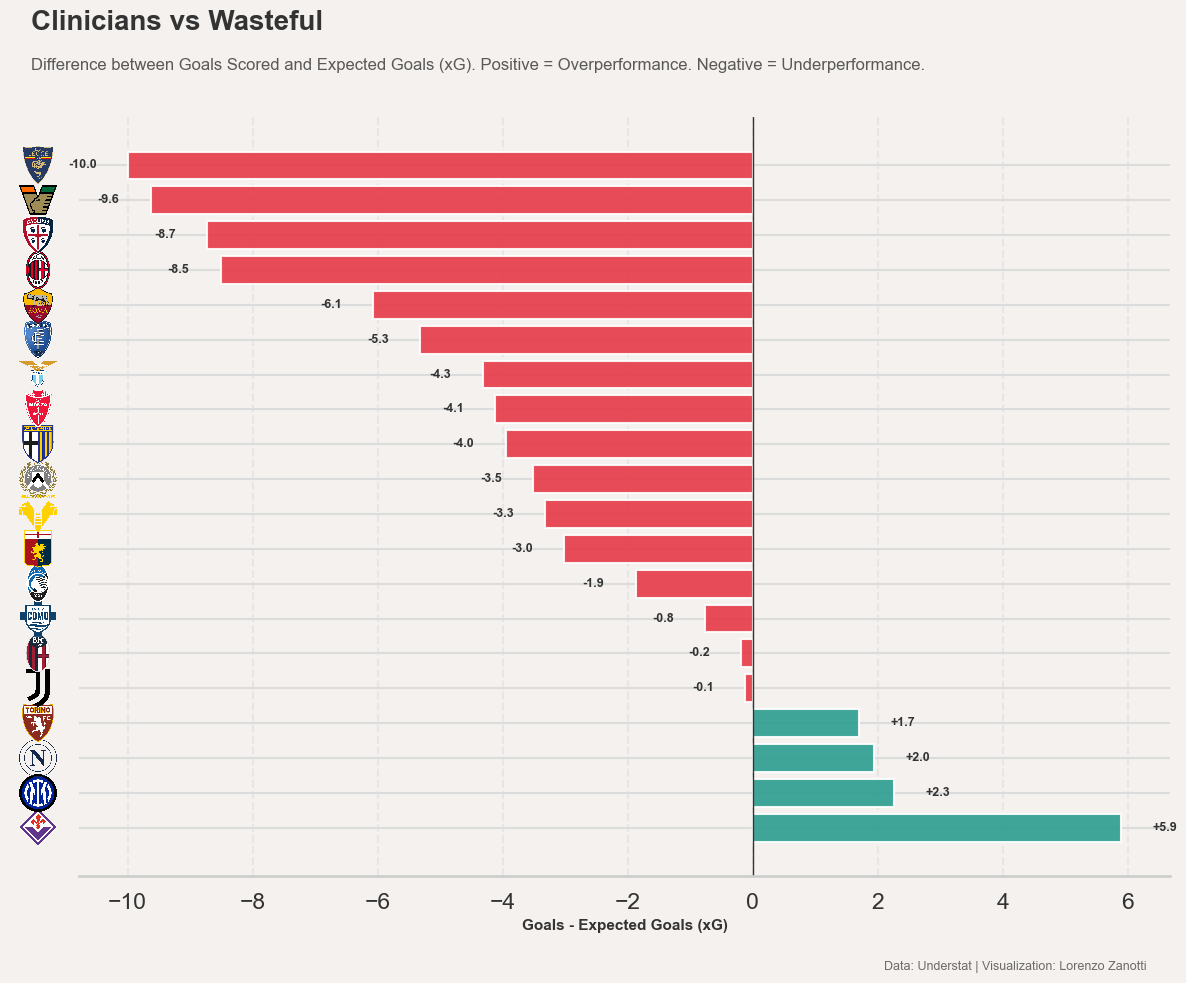

In [27]:
# =========================================================
# CHART 4: CLINICIANS VS WASTEFUL (Goals - xG)
# =========================================================

# --- 1. STYLE REFRESH ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': True
})

# --- 2. DATA PREP ---

# Sort: Top Overperformers (Clinicians) to Underperformers (Wasteful)
df_eff = df.sort_values("xg_overperf", ascending=False) 

# --- 3. PLOT GENERATION ---
fig, ax = plt.subplots(figsize=(12, 10))

# Diverging Colors: Green (Positive) / Red (Negative)
colors = ['#2A9D8F' if x >= 0 else '#E63946' for x in df_eff["xg_overperf"]]

# Horizontal Bar Chart
bars = ax.barh(df_eff["team"], df_eff["xg_overperf"], color=colors, alpha=0.9)

# --- 4. FORMATTING & LABELS ---
ax.axvline(0, color=TEXT_COLOR, linewidth=1)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Value Labels next to bars
for bar in bars:
    width = bar.get_width()
    # Position label slightly outside the bar
    label_x_pos = width + 0.5 if width > 0 else width - 0.5
    alignment = 'left' if width > 0 else 'right'
    
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:+.1f}', 
            va='center', ha=alignment, 
            fontsize=9, fontweight='bold', color=TEXT_COLOR)

# --- 5. REPLACE Y-LABELS WITH LOGOS ---
# Hide text labels
ax.set_yticklabels([])

# Add logos using the GLOBAL team_logo_map (from Cell 1)
for idx, (i, row) in enumerate(df_eff.iterrows()):
    team = row["team"]
    path = team_logo_map.get(team)
    
    if path and os.path.exists(path):
        try:
            img = imread(path)
            imagebox = OffsetImage(img, zoom=0.018) # Slightly larger for axis
            
            # Place logo using 'axes fraction' for X (left of axis) and 'data' for Y (bar position)
            ab = AnnotationBbox(imagebox, (-0.02, idx), 
                              xycoords=('axes fraction', 'data'),
                              box_alignment=(1, 0.5),
                              frameon=False)
            ax.add_artist(ab)
        except Exception:
            # Fallback to text if logo fails
            ax.text(0, idx, team, ha='right', va='center')

# --- 6. TITLES ---
ax.set_xlabel("Goals - Expected Goals (xG)", fontsize=11, fontweight='bold')
ax.set_ylabel("") # No label needed as logos explain it

fig.text(0.02, 0.96, "Clinicians vs Wasteful", 
         fontsize=20, fontweight='bold', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Difference between Goals Scored and Expected Goals (xG). Positive = Overperformance. Negative = Underperformance.", 
         fontsize=12, color=TEXT_COLOR, alpha=0.8)
fig.text(0.95, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", 
         ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
# Add extra left margin for logos
plt.subplots_adjust(left=0.06) 
plt.show()

### Reality vs Expectation

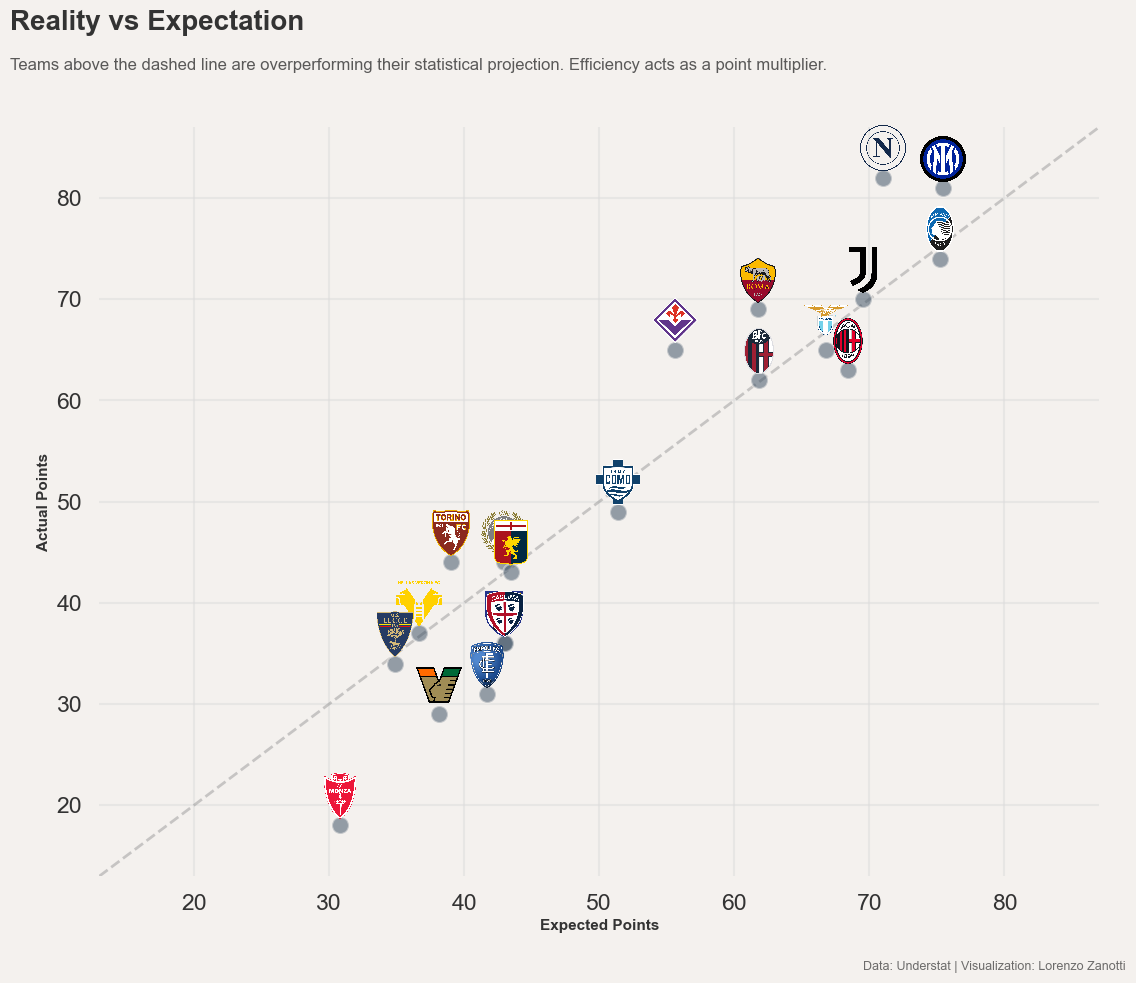

In [28]:
# =========================================================
# CHART 5: REALITY VS EXPECTATION (PTS vs xPTS)
# =========================================================

# --- 1. STYLE REFRESH ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': False
})

# --- 2. PLOT SETUP & LIMITS ---
fig, ax = plt.subplots(figsize=(12, 10))

# Calculate dynamic limits based on data range
all_pts = pd.concat([df['xPTS'], df['PTS']])
margin = 5
g_min, g_max = all_pts.min() - margin, all_pts.max() + margin

# Diagonal Line (The "Fairness Line")
ax.plot([g_min, g_max], [g_min, g_max], ls='--', color='#999999', alpha=0.5, lw=2, zorder=1)

# --- 3. SCATTER PLOT ---
sns.scatterplot(
    data=df, x='xPTS', y='PTS',
    s=150,             # Large bubbles
    color='#34495E',   # Neutral Elegant Grey
    alpha=0.5,         # Transparency to show grid
    edgecolor=BG_COLOR,
    linewidth=1.5,
    ax=ax,
    zorder=2
)

# --- 4. LOGOS PLACEMENT ---
for _, row in df.iterrows():
    # Logo placement logic: slightly above the point
    y_logo = row['PTS'] + 2.9
    
    # Use global helper function
    add_logo(ax, row['xPTS'], y_logo, row['team'], zoom=0.022)

# --- 5. FORMATTING & TEXT ---
ax.set_xlabel("Expected Points", fontsize=11, fontweight='bold')
ax.set_ylabel("Actual Points", fontsize=11, fontweight='bold')
ax.set_xlim(g_min, g_max)
ax.set_ylim(g_min, g_max)
ax.grid(alpha=0.5)

# Titles
fig.text(0.02, 0.96, "Reality vs Expectation",
         fontsize=20, fontweight='bold', ha='left', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Teams above the dashed line are overperforming their statistical projection. Efficiency acts as a point multiplier.",
         fontsize=12, ha='left', color=TEXT_COLOR, alpha=0.8)

# Footer
fig.text(0.95, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.90])
plt.show()

### Data Loading (Milan Comparison)

In [29]:
# =========================================================
# DATA LOADING: MILAN COMPARISON (24/25 vs 25/26)
# =========================================================

milan_file_path = os.path.join('data', 'Confronto MILAN.xlsx')

# Helper for metric cleaning
def clean_milan_metric(val):
    if isinstance(val, str):
        import re
        match = re.search(r"[-+]?\d*\.\d+|\d+", val)
        if match: return float(match.group())
    return float(val)

# Load & Clean
df_milan = pd.read_excel(milan_file_path)
df_milan['Season'] = df_milan['Season'].astype(str).str.strip()

metrics_to_clean = ['xG', 'xGA', 'xPTS', 'DC', 'ODC', 'G', 'GA', 'PPDA']
for col in metrics_to_clean:
    if col in df_milan.columns:
        df_milan[col] = df_milan[col].apply(clean_milan_metric)

# Feature Engineering (Per 90 stats)
df_milan['xG_pm'] = df_milan['xG'] / df_milan['M']
df_milan['G_pm'] = df_milan['G'] / df_milan['M']
df_milan['xGA_pm'] = df_milan['xGA'] / df_milan['M']
df_milan['GA_pm'] = df_milan['GA'] / df_milan['M']
df_milan['DC_pm'] = df_milan['DC'] / df_milan['M']
df_milan['ODC_pm'] = df_milan['ODC'] / df_milan['M']
df_milan['PPDA_val'] = df_milan['PPDA']
df_milan['Efficiency_pm'] = df_milan['G_pm'] - df_milan['xG_pm']

# Extract Seasons
s24 = df_milan[df_milan['Season']=='24/25'].iloc[0]
s25 = df_milan[df_milan['Season']=='25/26'].iloc[0]

print("Milan comparison data loaded successfully.")
display(df_milan)

Milan comparison data loaded successfully.


,№,Team,M,W,D,L,G,GA,PTS,xG,...,xPTS,Season,xG_pm,G_pm,xGA_pm,GA_pm,DC_pm,ODC_pm,PPDA_val,Efficiency_pm
0,8,AC Milan,38,18,9,11,61.0,43.0,63,69.51,...,68.40,24/25,1.829211,1.605263,1.243947,1.131579,7.605263,5.315789,12.27,-0.223947
1,2,AC Milan,15,9,5,1,24.0,13.0,32,26.30,...,28.55,25/26,1.753333,1.600000,1.047333,0.866667,8.133333,5.200000,16.61,-0.153333


### Milan's Trade-Off

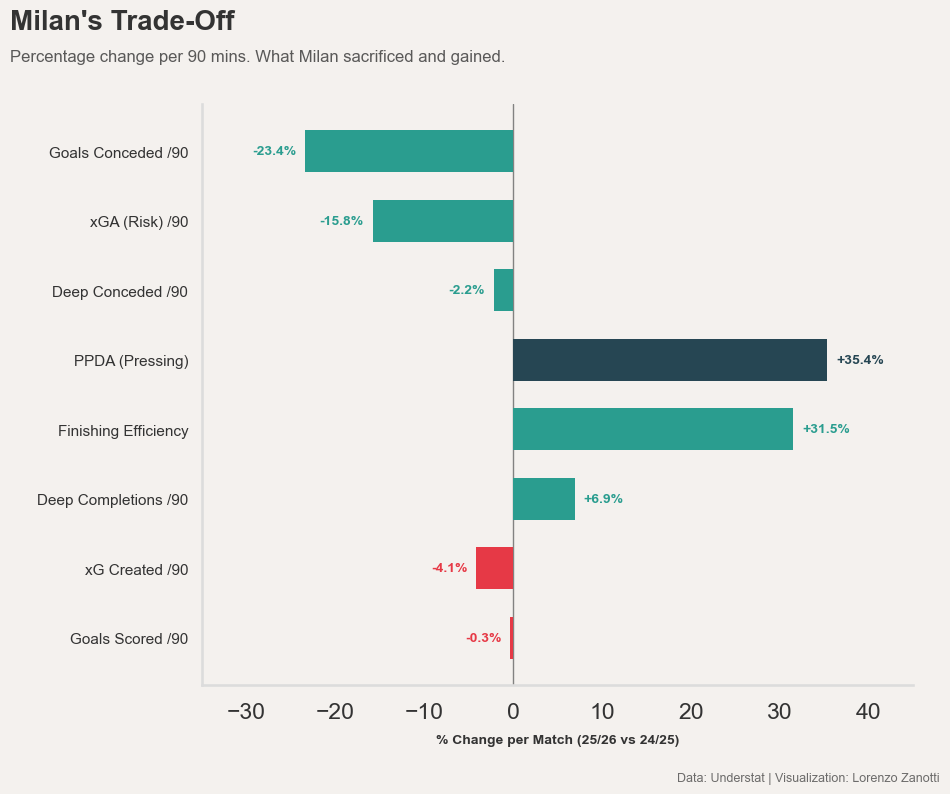

In [30]:
# =========================================================
# CHART 6: MILAN EVOLUTION (Trade-Off)
# =========================================================

# --- 1. STYLE REFRESH ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 
    'axes.spines.top': False, 
    'axes.spines.right': False,
    'axes.spines.left': True,   
    'axes.spines.bottom': True, 
    'axes.edgecolor': GRID_COLOR 
})

# --- 2. DATA PREP FOR PLOT ---
metrics_ordered = [
    ('GA_pm', 'Goals Conceded /90'), 
    ('xGA_pm', 'xGA (Risk) /90'),
    ('ODC_pm', 'Deep Conceded /90'), 
    ('PPDA_val', 'PPDA (Pressing)'),
    ('Efficiency_pm', 'Finishing Efficiency'), 
    ('DC_pm', 'Deep Completions /90'), 
    ('xG_pm', 'xG Created /90'),
    ('G_pm', 'Goals Scored /90')
]

diffs = []
colors = []
labels = []
text_labels = []

# Palette 
POS_COLOR = '#2A9D8F' 
NEG_COLOR = '#E63946' 
NEUT_COLOR = '#264653' 

for col, label in metrics_ordered:
    val24 = s24[col]
    val25 = s25[col]
    
    if col == 'Efficiency_pm':
        pct = ((val25 - val24) / abs(val24)) * 100
    else:
        pct = ((val25 - val24) / val24) * 100
    
    diffs.append(pct)
    labels.append(label)
    text_labels.append(f"{pct:+.1f}%")

    if col in ['GA_pm', 'xGA_pm', 'ODC_pm']:
        colors.append(POS_COLOR if pct < 0 else NEG_COLOR)
    elif col == 'PPDA_val':
        colors.append(NEUT_COLOR)
    else:
        colors.append(POS_COLOR if pct > 0 else NEG_COLOR)

# --- 3. PLOT GENERATION ---
fig, ax = plt.subplots(figsize=(10, 8))

# Zero Line 
ax.axvline(0, color='#666666', linewidth=1.0, alpha=0.8, zorder=2)

# Delete the grid
ax.grid(False)

# Bars
y_pos = np.arange(len(metrics_ordered))
ax.barh(y_pos, diffs, color=colors, height=0.6, zorder=3, edgecolor='none')

# Value Labels
for i, v in enumerate(diffs):
    offset = 1 if v >= 0 else -1
    ha = 'left' if v >= 0 else 'right'
    ax.text(v + offset, i, text_labels[i], va='center', ha=ha, 
            fontweight='bold', fontsize=10, color=colors[i], zorder=5)

# --- 4. FORMATTING ---
ax.invert_yaxis()
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=11, fontweight='normal', color=TEXT_COLOR)

ax.tick_params(axis='y', length=0, pad=10) 
ax.set_xlim(-35, 45)
ax.set_xlabel('% Change per Match (25/26 vs 24/25)', fontweight='bold', fontsize=10, labelpad=8, color=TEXT_COLOR)

# Titles
fig.text(0.02, 0.96, "Milan's Trade-Off", fontsize=20, fontweight='bold', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Percentage change per 90 mins. What Milan sacrificed and gained.", fontsize=12, color=TEXT_COLOR, alpha=0.8)
fig.text(0.95, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.90])
plt.show()

### Data Prep & Percentile Calculation

In [31]:
# =========================================================
# DATA PREP: SEASON COMPARISON (PERCENTILES)
# =========================================================

from scipy.stats import percentileofscore
from math import pi

# Paths
path_24 = DATA_PATH
path_25 = os.path.join('data', 'UnderStat25-26.xlsx')

# 1. ROBUST CLEANING FUNCTION
def clean_val(val):
    if pd.isna(val): return 0.0
    if isinstance(val, (int, float)): return float(val)
    # Handle string cases like "10+2" or "5-1" if present
    s = str(val).strip()
    if '+' in s: s = s.split('+')[0]
    elif '-' in s and not s.startswith('-'): s = s.split('-')[0]
    
    import re
    match = re.search(r"[-+]?\d*\.\d+|[-+]?\d+", s)
    return float(match.group()) if match else 0.0

# 2. LOADING & PROCESSING FUNCTION
def load_and_prep_season(path):
    d = pd.read_excel(path)
    
    # Rename for consistency if needed
    rename_map = {'Deep': 'DC', 'Deep_Allowed': 'ODC', 'M': 'matches'}
    d.rename(columns=rename_map, inplace=True)
    
    # Metrics to process
    metrics_raw = ['xG', 'G', 'xGA', 'GA', 'DC', 'ODC', 'PPDA']
    
    for col in metrics_raw:
        if col in d.columns:
            d[col] = d[col].apply(clean_val)
            if 'matches' in d.columns:
                # Create p90 except for PPDA
                if col != 'PPDA':
                    d[f'{col}_p90'] = d[col] / d['matches']
                else:
                    d[f'{col}_val'] = d[col]
    return d

df24 = load_and_prep_season(path_24)
df25 = load_and_prep_season(path_25)

# 3. CONFIGURATION & CALCULATION
metrics_cfg = [
    {'col': 'G_p90', 'label': 'Goals', 'invert': False},
    {'col': 'xG_p90', 'label': 'xG', 'invert': False},
    {'col': 'DC_p90', 'label': 'Deep Compl.', 'invert': False},
    {'col': 'PPDA_val', 'label': 'Pressing', 'invert': True}, # Low PPDA = High Percentile (Better)
    {'col': 'ODC_p90', 'label': 'Deep Conc.', 'invert': True}, 
    {'col': 'xGA_p90', 'label': 'xGA', 'invert': True},      
    {'col': 'GA_p90', 'label': 'Goals Conc.', 'invert': True} 
]

def get_team_percentiles(df_season, team_name='Milan'):
    # Find team row (case insensitive)
    mask = df_season['Team'].astype(str).str.contains(team_name, case=False, na=False)
    if not mask.any():
        print(f"Team {team_name} not found.")
        return [0]*len(metrics_cfg)
    
    team_stats = df_season[mask].iloc[0]
    percentiles = []
    
    for m in metrics_cfg:
        col = m['col']
        if col not in df_season.columns:
            percentiles.append(0)
            continue
        
        val = team_stats[col]
        all_vals = df_season[col].dropna().values
        
        # Calculate rank
        pct = percentileofscore(all_vals, val, kind='weak')
        
        # Invert if needed (e.g. Defense: lower is better -> higher percentile)
        if m['invert']: 
            pct = 100 - pct
        percentiles.append(pct)
        
    return percentiles

# Calculate Milan's ranks for both years
p24 = get_team_percentiles(df24, 'Milan')
p25 = get_team_percentiles(df25, 'Milan')

### The Structural Transformation

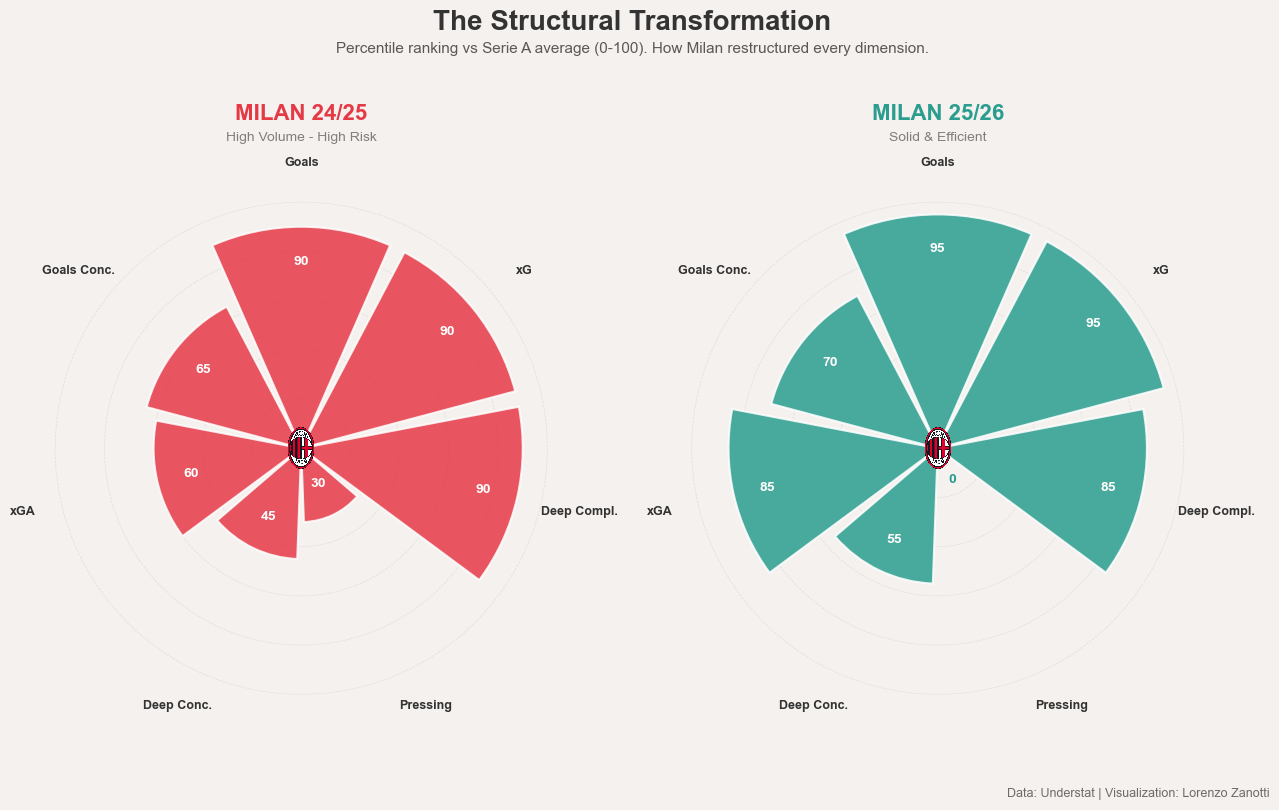

In [32]:
# =========================================================
# CHART 7: STRUCTURAL TRANSFORMATION (RADAR/PIZZA)
# =========================================================

# --- 1. STYLE & COLORS ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
COLOR_24 = '#E63946' # Red
COLOR_25 = '#2A9D8F' # Teal

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR
})

# --- 2. HELPER: POLAR LOGO ---
def add_logo_polar_center(ax, team_name, zoom=0.15):
    """Adds logo to the center (0,0) of a polar plot using GLOBAL team_logo_map."""
    # Use the global map defined in Cell 1
    path = team_logo_map.get(team_name) 
    if path and os.path.exists(path):
        img = imread(path)
        im = OffsetImage(img, zoom=zoom)
        # In polar, (0,0) is the center
        ab = AnnotationBbox(im, (0, 0), frameon=False, box_alignment=(0.5, 0.5))
        ax.add_artist(ab)

# --- 3. PLOT GENERATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8.5), subplot_kw=dict(polar=True))

def create_pizza_optimized(ax, percentiles, color, title, subtitle):
    # Setup Angles
    N = len(metrics_cfg)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    width = 2 * pi / N
    
    # Rotate plot so 0 is at top (12 o'clock)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Background Rings (0, 20, 40, 60, 80, 100)
    for i in [20, 40, 60, 80, 100]:
        ax.bar(angles, [i]*N, width=width, color='white', edgecolor='#E0E0E0', 
               linewidth=0.5, alpha=0.0, zorder=0)
        ax.plot(np.linspace(0, 2*pi, 100), [i]*100, color='#CCCCCC', 
                linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Data Bars
    ax.bar(angles, percentiles, width=width*0.92, color=color, 
           alpha=0.85, edgecolor='white', linewidth=1.5, zorder=2)
    
    # Labels (Metrics)
    ax.set_xticks(angles)
    ax.set_xticklabels([m['label'] for m in metrics_cfg], size=9, 
                       fontweight='bold', color=TEXT_COLOR)
    
    # Value Labels (The Percentile Number)
    for angle, p in zip(angles, percentiles):
        # If bar is very low, put text outside
        offset = -14 if p > 15 else 14
        text_color = 'white' if p > 15 else color
        
        ax.text(angle, p + offset, f"{int(p)}", ha='center', va='center', 
               color=text_color, fontweight='bold', fontsize=10, zorder=3)
    
    # Clean up axes
    ax.set_yticks([]) # Hide radial numbers
    ax.spines['polar'].set_visible(False) # Hide outer circle
    ax.grid(False)
    
    # Logo Center
    add_logo_polar_center(ax, 'Milan', zoom=0.020) # Corrected zoom for polar center
    
    # Individual Titles
    ax.set_title(title, y=1.12, fontsize=16, fontweight='bold', color=color)
    ax.text(0, 125, subtitle, ha='center', fontsize=10, alpha=0.6, color=TEXT_COLOR)

# Create the two charts
create_pizza_optimized(ax1, p24, COLOR_24, "MILAN 24/25", "High Volume - High Risk")
create_pizza_optimized(ax2, p25, COLOR_25, "MILAN 25/26", "Solid & Efficient")

# --- 4. GLOBAL TITLES & FOOTER ---
fig.suptitle("The Structural Transformation", fontsize=20, fontweight='bold', 
             color=TEXT_COLOR, y=0.94)
fig.text(0.5, 0.89, "Percentile ranking vs Serie A average (0-100). How Milan restructured every dimension.", 
         ha='center', fontsize=11, color=TEXT_COLOR, alpha=0.8)

# Footer
fig.text(0.99, 0.01, "Data: Understat | Visualization: Lorenzo Zanotti", 
         ha='right', va='bottom', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.88]) 
plt.show()